# IRAM Data Example

Trey V. Wenger (c) December 2024

Here we test `bayes_cn_hfs` on some real IRAM 30-m data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+5.gba85b08.dirty


## Load the data

12CN-1/2 650
12CN-3/2 551
13CN-1/2 550
13CN-3/2 550


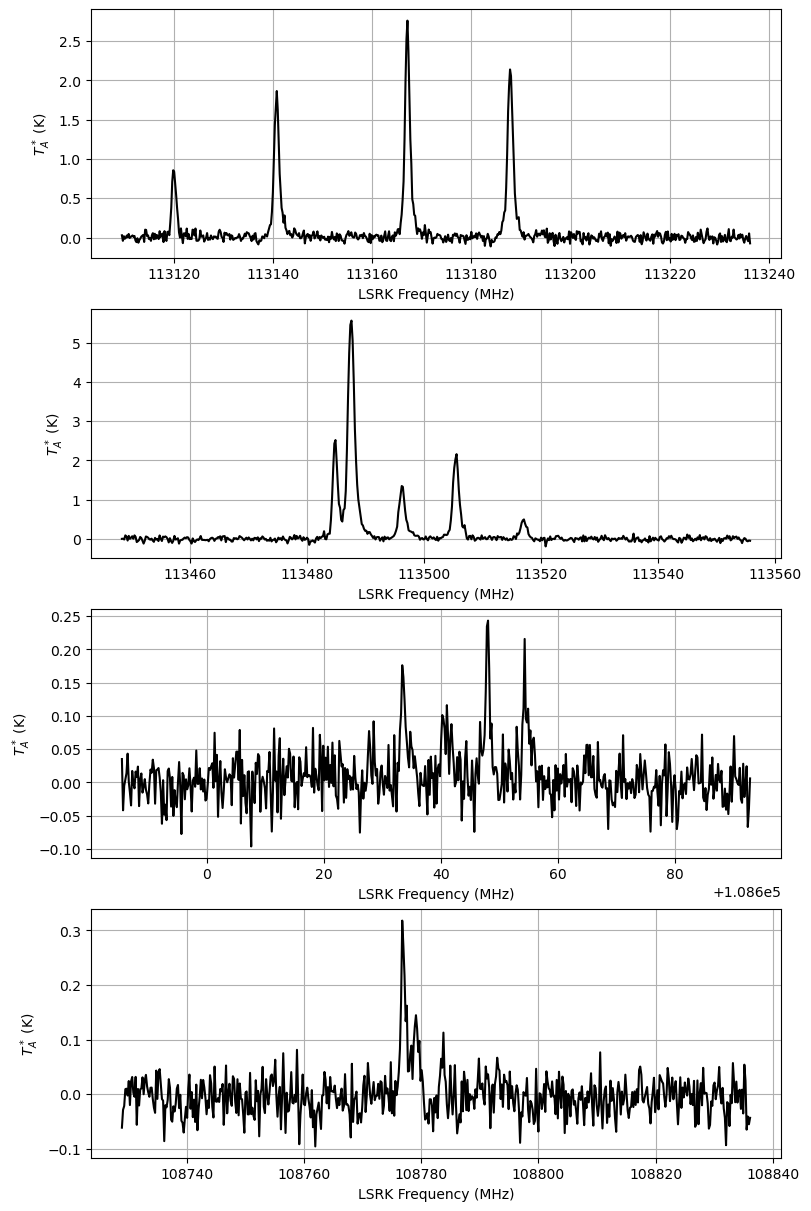

In [2]:
from bayes_spec import SpecData
import pickle

with open("iram_data.pkl", "rb") as f:
    iram_data = pickle.load(f)

labels = ["12CN-1/2", "12CN-3/2", "13CN-1/2", "13CN-3/2"]
data = {
    label: SpecData(
        iram_data[f"frequency_{label}"][500:-500],
        iram_data[f"spectrum_{label}"][500:-500],
        iram_data[f"rms_{label}"],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_A^*$ (K)",
    )
    for label in labels
}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in labels if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, label in enumerate(labels):
    axes[i].plot(data[label].spectral, data[label].brightness, 'k-')
    axes[i].set_xlabel(data[label].xlabel)
    axes[i].set_ylabel(data[label].ylabel)

## Inspecting the CN data

Can we constrain the excitation temperature and optical depth? How about the hyperfine anomalies? It seems like there is only one cloud component, so let's explore the data with that assumption for now. We assume make the weak LTE assumption such that the kinetic temperature is equal to the mean cloud excitation temperature. We are otherwise unable to constrain the kinetic temperature because non-thermal broadening is important and we have poor spectral resolution.

In [3]:
from bayes_cn_hfs.cn_model import CNModel
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

n_clouds = 1
baseline_degree = 0
model = CNModel(
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.5, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # weak LTE assumption
    prior_log10_Tkin = [1.0, 0.25], # mean and width of kinetic temperature = mean cloud excitation temperature prior (K)
    prior_velocity = [10.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # weak LTE assumption
    prior_log_boltz_factor_sigma = 1.0, # width of log Boltzmann factor hyperfine anomaly prior
    fix_log10_Tkin = None, # do not assume a kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 0 from lower state 0
Transition 113191.325 is constraining upper state 1 from lower state 0
Transition 113490.985 is constraining upper state 4 from lower state 0
Transition 113508.934 is constraining upper state 3 from lower state 0
Transition 113520.4215 is constraining upper state 2 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 0
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]


Sampling: [12CN-1/2, 12CN-3/2, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tkin_norm, log_boltz_factor_free_norm, log_boltz_factor_sigma_norm, velocity_norm]


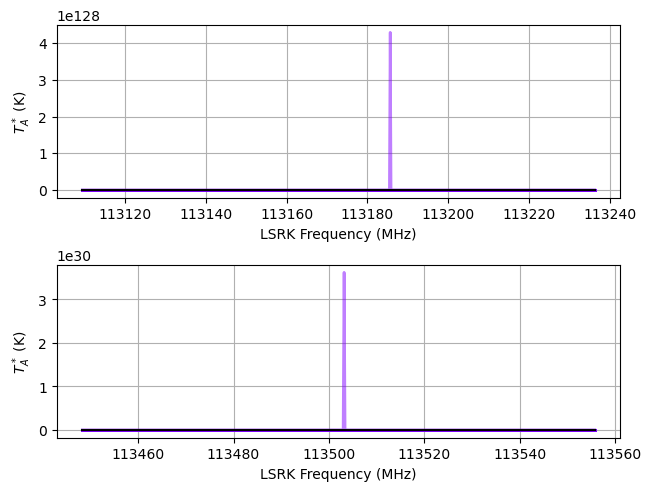

In [4]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [5]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 4300
Interrupted at 4,299 [4%]: Average Loss = 9.0817e+13


Output()

Runtime: 0.99 minutes


In [6]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "transition_free", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N0[0],13.812,0.002,13.808,13.816,0.000,0.000,1026.0,954.0,NaN
log10_Tkin[0],1.151,0.003,1.144,1.157,0.000,0.000,958.0,1023.0,NaN
log10_Tex_mean[0],1.151,0.003,1.144,1.157,0.000,0.000,958.0,1023.0,NaN
log_boltz_factor_sigma[0],0.243,0.005,0.235,0.253,0.000,0.000,1009.0,757.0,NaN
log10_N[0],14.465,0.003,14.460,14.471,0.000,0.000,1088.0,982.0,NaN
velocity[0],9.122,0.007,9.109,9.135,0.000,0.000,1056.0,1024.0,NaN
fwhm_thermal[0],0.158,0.001,0.157,0.159,0.000,0.000,958.0,1023.0,NaN
fwhm_nonthermal[0],2.758,0.022,2.716,2.799,0.001,0.001,896.0,752.0,NaN
fwhm[0],2.763,0.022,2.720,2.804,0.001,0.001,896.0,752.0,NaN
tau_total[0],1.724,0.062,1.622,1.849,0.002,0.001,940.0,983.0,NaN


Sampling: [12CN-1/2, 12CN-3/2]


Output()

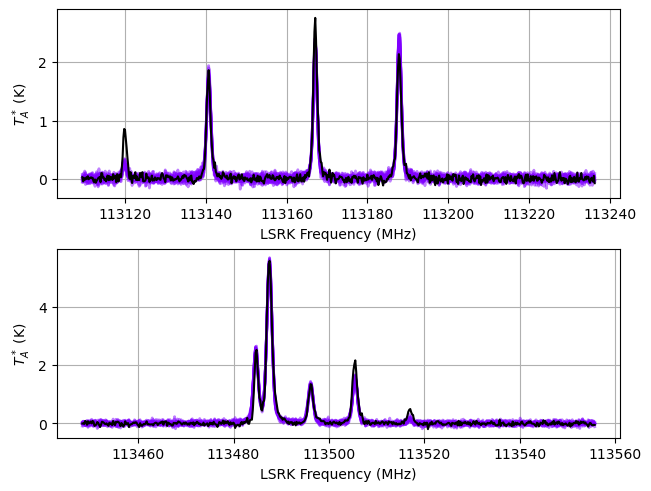

In [7]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Number of cloud components
We first explore the CN data, which have greater signal-to-noise, in order to constrain the optical depths, excitation temperatures, and number of cloud components. We assume make the weak LTE assumption such that the kinetic temperature is equal to the mean cloud excitation temperature. We are otherwise unable to constrain the kinetic temperature because non-thermal broadening is important and we have poor spectral resolution.

In [8]:
from bayes_cn_hfs.cn_model import CNModel
from bayes_cn_hfs import get_molecule_data
from bayes_spec import Optimize

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

max_n_clouds = 6
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N0 = [13.5, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # weak LTE assumption
    prior_log10_Tkin = [1.0, 0.25], # mean and width of kinetic temperature = mean cloud excitation temperature prior (K)
    prior_velocity = [10.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # weak LTE assumption
    prior_log_boltz_factor_sigma = 0.1, # width of log Boltzmann factor hyperfine anomaly prior
    fix_log10_Tkin = None, # do not assume a kinetic temperature
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Transition 113144.19 is constraining upper state 0 from lower state 0
Transition 113191.325 is constraining upper state 1 from lower state 0
Transition 113490.985 is constraining upper state 4 from lower state 0
Transition 113508.934 is constraining upper state 3 from lower state 0
Transition 113520.4215 is constraining upper state 2 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 0
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 113144.19 is constraining upper state 0 from lower state 0
Transition 113191.325 is constraining upper state 1 from lower state 0
Transition 113490.985 is constraining upper state 4 from lower state 0
Transition 113508.934 is constraining upper state 3 from lower state 0
Transition 113520.4215 is constraining upper state 2 from lower state 0
Transition 1

Sampling: [12CN-1/2, 12CN-3/2, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tkin_norm, log_boltz_factor_free_norm, log_boltz_factor_sigma_norm, velocity_norm]


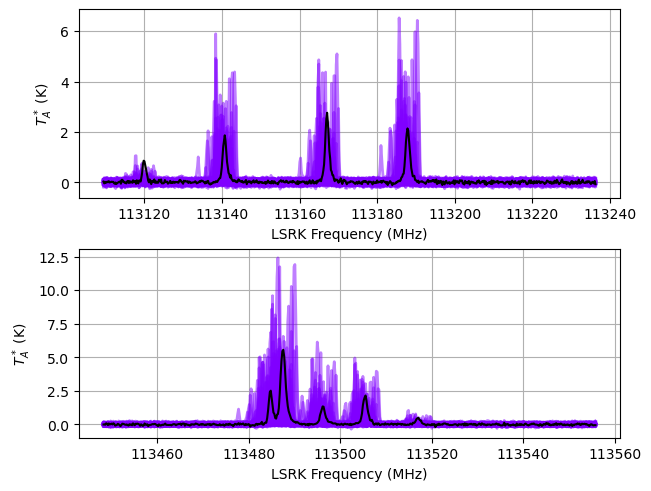

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

## Optimize number of clouds with Variational Inference

In [10]:
start = time.time()
fit_kwargs = {
    "n": 20_000,
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.01,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.570e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 3600
Interrupted at 3,599 [17%]: Average Loss = 6,618.8


Output()

n_cloud = 1 BIC = -1.299e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 5800
Interrupted at 5,799 [28%]: Average Loss = 2,658.3


Output()

n_cloud = 2 BIC = -2.455e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 5500
Interrupted at 5,499 [27%]: Average Loss = 2,492.9


Output()

n_cloud = 3 BIC = -2.684e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 6100
Interrupted at 6,099 [30%]: Average Loss = 1,857.1


Output()

n_cloud = 4 BIC = -2.966e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 6000
Interrupted at 5,999 [29%]: Average Loss = 2,064.9


Output()

n_cloud = 5 BIC = -2.912e+03

Approximating n_cloud = 6 posterior...


Output()

Convergence achieved at 6100
Interrupted at 6,099 [30%]: Average Loss = 1,952.9


Output()

n_cloud = 6 BIC = -2.835e+03

Runtime: 11.08 minutes


[95704.84851857 -1299.34922472 -2454.60811694 -2684.15846221
 -2965.5153668  -2911.72268996 -2835.11303166]


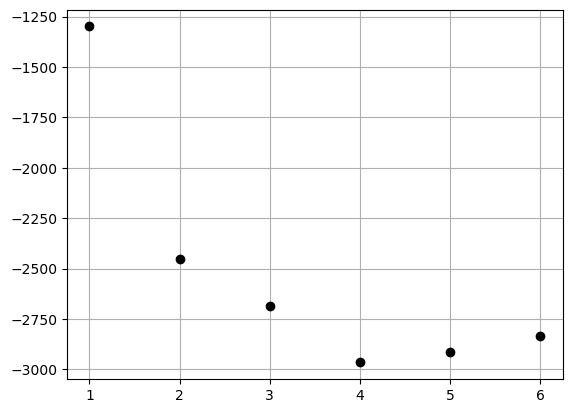

In [11]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko')

In [12]:
model = opt.models[4]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "transition_free", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N0[0],14.110,0.011,14.092,14.131,0.000,0.000,1024.0,865.0,NaN
log10_N0[1],14.415,0.023,14.374,14.456,0.001,0.001,1035.0,1023.0,NaN
log10_N0[2],13.617,0.011,13.596,13.638,0.000,0.000,998.0,951.0,NaN
log10_N0[3],13.765,0.010,13.745,13.784,0.000,0.000,935.0,860.0,NaN
log10_Tkin[0],0.886,0.001,0.884,0.889,0.000,0.000,921.0,952.0,NaN
log10_Tkin[1],0.707,0.003,0.702,0.713,0.000,0.000,937.0,1070.0,NaN
log10_Tkin[2],0.824,0.008,0.811,0.840,0.000,0.000,1026.0,912.0,NaN
log10_Tkin[3],1.110,0.013,1.086,1.137,0.000,0.000,979.0,907.0,NaN
log10_Tex_mean[0],0.886,0.001,0.884,0.889,0.000,0.000,921.0,952.0,NaN
log10_Tex_mean[1],0.707,0.003,0.702,0.713,0.000,0.000,937.0,1070.0,NaN


Sampling: [12CN-1/2, 12CN-3/2]


Output()

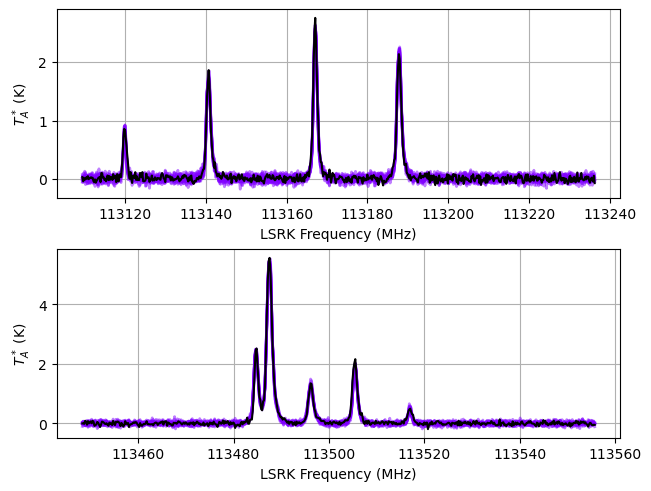

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

Let's compare the BICs to MCMC.

In [ ]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.01,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 20_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.570e+04
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [17%]: Average Loss = 6,618.8
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, log10_N0_norm, log10_Tkin_norm, log_boltz_factor_sigma_norm, log_boltz_factor_free_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1506 seconds.


Adding log-likelihood to trace


Output()

There were 736 divergences in converged chains.
GMM converged to unique solution
7 of 8 chains appear converged.
n_cloud = 1 solution = 0 BIC = -1.659e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5800
Interrupted at 5,799 [28%]: Average Loss = 2,658.3
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, log10_N0_norm, log10_Tkin_norm, log_boltz_factor_sigma_norm, log_boltz_factor_free_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()